In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

from matplotlib import gridspec
from theano import tensor as tt
from scipy import stats

# Chapter 13 - Extrasensory perception

## 13.1 Evidence for optional stopping
The negative relation between the number of subjects and effect size suggests that the results are contaminated by optional stopping. Here we inferred on the correlation coefficient (same as in chapter 5):  

$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ x_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 95%|█████████▌| 3335/3500.0 [00:21<00:01, 121.74it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 1 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 3493/3500.0 [00:22<00:00, 172.20it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3500/3500.0 [00:22<00:00, 152.69it/s]


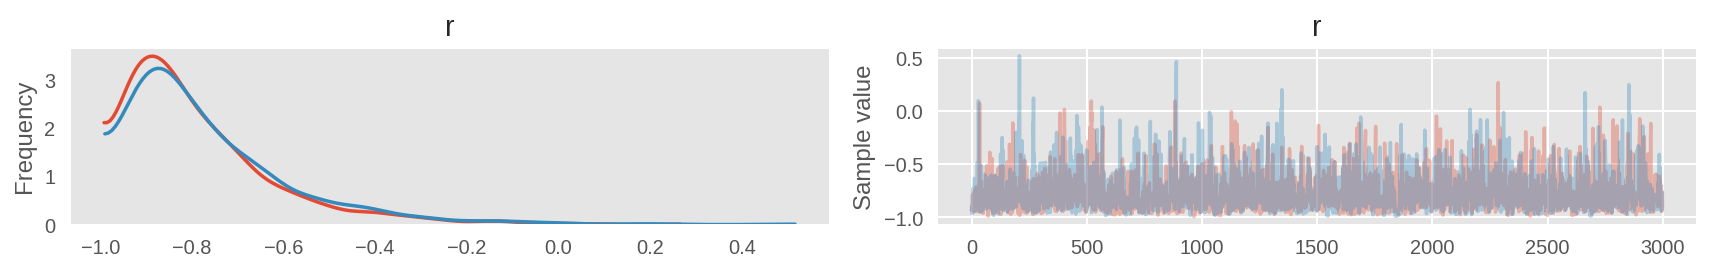

In [2]:
# Sample size N and effect size E in the Bem experiments
N = np.array([100, 150, 97, 99, 100, 150, 200, 100, 50])
E = np.array([.25, .20, .25, .20, .22, .15, .09, .19, .42])

y = np.vstack([N, E]).T
n,n2 = np.shape(y) # number of experiments

with pm.Model() as model1:
    # r∼Uniform(−1,1)
    r = pm.Uniform('r', lower=-1, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))
    
    tau1 = pm.Deterministic('tau1', tt.nlinalg.matrix_inverse(cov))
    
    yd = pm.MvNormal('yd', mu=mu, tau=tau1, observed=y)

    trace1=pm.sample(3e3, njobs=2)

pm.traceplot(trace1, varnames=['r']);

the Bayes Factor is 16.44719
the approximation Jeffreys Bayes Factor is 16.19579
the exact Jeffreys Bayes Factor is 21.53765


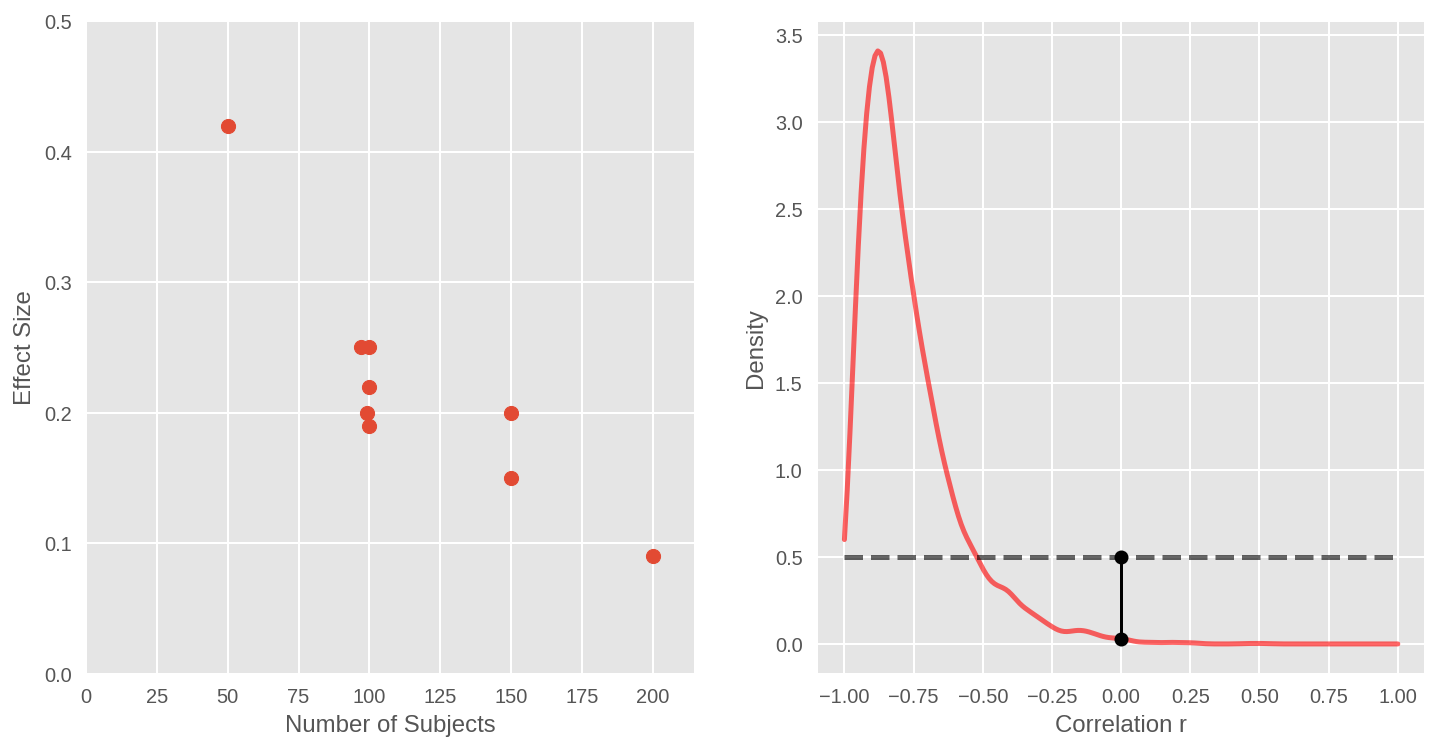

In [3]:
from scipy.stats.kde import gaussian_kde
burnin=50
r = trace1['r'][burnin:]

fig = plt.figure(figsize=(12, 6)) 

gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
ax0.scatter(y[:, 0], y[:, 1], s=50)
plt.axis([0, 215, 0, .5])
plt.xlabel('Number of Subjects')
plt.ylabel('Effect Size')

my_pdf = gaussian_kde(r)
x=np.linspace(-1, 1, 200)
ax1 = plt.subplot(gs[1])
ax1.plot(x, my_pdf(x), 'r', lw=2.5, alpha=0.6,) # distribution function
ax1.plot(x, np.ones(x.size)*.5, 'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)             # this gives the pdf at point delta = 0
prior     = .5       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f'%(1/BF01))
ax1.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko',
         lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlabel('Correlation r')
plt.ylabel('Density')

# Compare to approximation Jeffreys (1961), pp. 289-292:
import scipy as scipy 
freqr=scipy.corrcoef(y[:, 0], y[:, 1])
BF_Jeffrey=1/(((2*(n-1)-1)/np.pi)**.5 * (1-freqr[0,1]**2)**(.5*((n-1)-3)))
print ('the approximation Jeffreys Bayes Factor is %.5f'%(BF_Jeffrey))

# Compare to exact solution Jeffreys (numerical integration):
BF_Jeffex = scipy.integrate.quad(lambda rho: ((1-rho**2)**((n-1)/2)) / ((1-rho*freqr[0,1])**((n-1)-.5)), -1, 1)
print('the exact Jeffreys Bayes Factor is %.5f'%(BF_Jeffex[0]/2))

plt.show()

## 13.2 Evidence for differences in ability
  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (0, 1) $$  
$$ \hat\theta_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$  
$$ \theta_{ij} =  \Phi(\hat\theta_{ij})$$
$$ k_{ij} \sim \text{Binomial}(\theta_{ij},n)$$

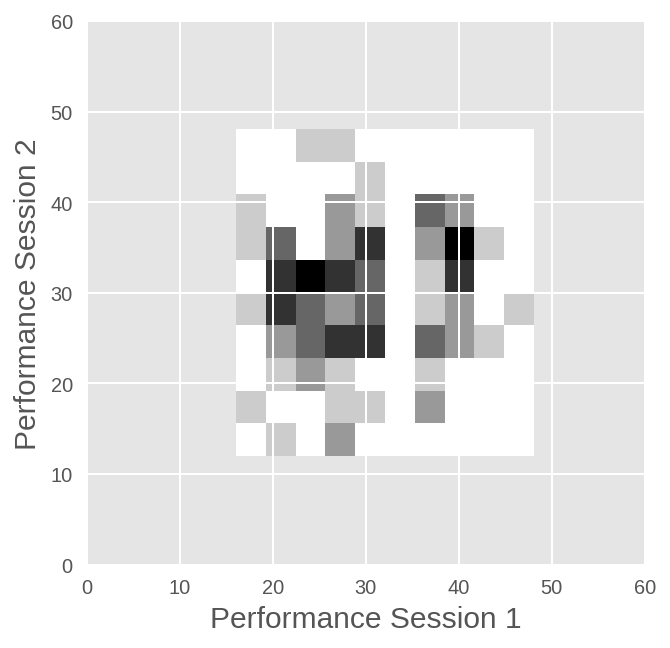

In [4]:
# Data
# Proportion correct on erotic pictures, block 1 and block 2:
prc1er=np.array([0.6000000, 0.5333333, 0.6000000, 0.6000000, 0.4666667, 
                 0.6666667, 0.6666667, 0.4000000, 0.6000000, 0.6000000,
                 0.4666667, 0.6666667, 0.4666667, 0.6000000, 0.3333333,
                 0.4000000, 0.4000000, 0.2666667, 0.3333333, 0.5333333,
                 0.6666667, 0.5333333, 0.6000000, 0.4000000, 0.4666667, 
                 0.7333333, 0.6666667, 0.6000000, 0.6666667, 0.5333333,
                 0.5333333, 0.6666667, 0.4666667, 0.3333333, 0.4000000,
                 0.5333333, 0.4000000, 0.4000000, 0.3333333, 0.4666667,
                 0.4000000, 0.4666667, 0.4666667, 0.5333333, 0.3333333,
                 0.7333333, 0.2666667, 0.6000000, 0.5333333, 0.4666667,
                 0.4000000, 0.5333333, 0.6666667, 0.4666667, 0.5333333,
                 0.5333333, 0.4666667, 0.4000000, 0.4666667, 0.6666667,
                 0.4666667, 0.3333333, 0.3333333, 0.3333333, 0.4000000,
                 0.4000000, 0.6000000, 0.4666667, 0.3333333, 0.3333333,
                 0.6666667, 0.5333333, 0.3333333, 0.6000000, 0.4666667,
                 0.4666667, 0.4000000, 0.3333333, 0.4666667, 0.5333333,
                 0.8000000, 0.4000000, 0.5333333, 0.5333333, 0.6666667,
                 0.6666667, 0.6666667, 0.6000000, 0.6000000, 0.5333333,
                 0.3333333, 0.4666667, 0.6666667, 0.5333333, 0.3333333,
                 0.3333333, 0.2666667, 0.2666667, 0.4666667, 0.6666667])

prc2er=np.array([0.3333333, 0.6000000, 0.5333333, 0.2666667, 0.6666667,
                 0.5333333, 0.6666667, 0.4666667, 0.4666667, 0.6666667,
                 0.4000000, 0.6666667, 0.2666667, 0.4000000, 0.4666667,
                 0.3333333, 0.5333333, 0.6000000, 0.3333333, 0.4000000,
                 0.4666667, 0.4666667, 0.6000000, 0.5333333, 0.5333333,
                 0.6000000, 0.5333333, 0.6666667, 0.6000000, 0.2666667,
                 0.4666667, 0.4000000, 0.6000000, 0.5333333, 0.4000000,
                 0.4666667, 0.5333333, 0.3333333, 0.4000000, 0.4666667,
                 0.8000000, 0.6000000, 0.2000000, 0.6000000, 0.4000000,
                 0.4000000, 0.2666667, 0.2666667, 0.6000000, 0.4000000,
                 0.4000000, 0.4000000, 0.4000000, 0.4000000, 0.6666667,
                 0.7333333, 0.5333333, 0.5333333, 0.3333333, 0.6000000,
                 0.5333333, 0.5333333, 0.4666667, 0.5333333, 0.4666667,
                 0.5333333, 0.4000000, 0.4000000, 0.4666667, 0.6000000,
                 0.6000000, 0.6000000, 0.4666667, 0.6000000, 0.6666667,
                 0.5333333, 0.4666667, 0.6000000, 0.2000000, 0.5333333,
                 0.4666667, 0.4000000, 0.5333333, 0.5333333, 0.5333333,
                 0.5333333, 0.6000000, 0.6666667, 0.4000000, 0.4000000,
                 0.5333333, 0.8000000, 0.6000000, 0.4000000, 0.2000000,
                 0.6000000, 0.6666667, 0.4666667, 0.4666667, 0.4666667])             
Nt = 60
xobs = np.vstack([prc1er, prc2er]).T*Nt
n,n2 = np.shape(xobs) # number of participants

plt.figure(figsize=[5, 5])
plt.hist2d(xobs[:, 0], xobs[:, 1], cmap = 'binary')
plt.xlabel('Performance Session 1', fontsize=15)
plt.ylabel('Performance Session 2', fontsize=15)
plt.axis([0, 60, 0, 60])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500.0 [01:05<00:00, 53.25it/s]


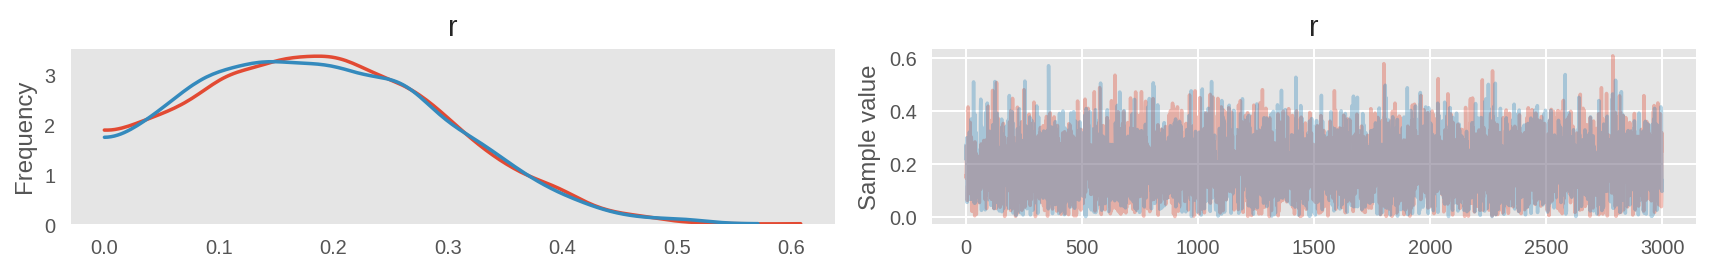

In [8]:
def phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

with pm.Model() as model2:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r', lower=0, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001, testval=100)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001, testval=100)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))
    
    tau1 = pm.Deterministic('tau1', tt.nlinalg.matrix_inverse(cov))

    thetai = pm.MvNormal('thetai', mu=mu, tau=tau1, shape=(n, n2))
    theta = phi(thetai)
    kij = pm.Binomial('kij', p=theta, n=Nt, observed=xobs)
    
    trace2=pm.sample(3e3, njobs=2)

pm.traceplot(trace2, varnames=['r']);

the Bayes Factor is 1.13844
the exact Jeffreys Bayes Factor is 0.45612


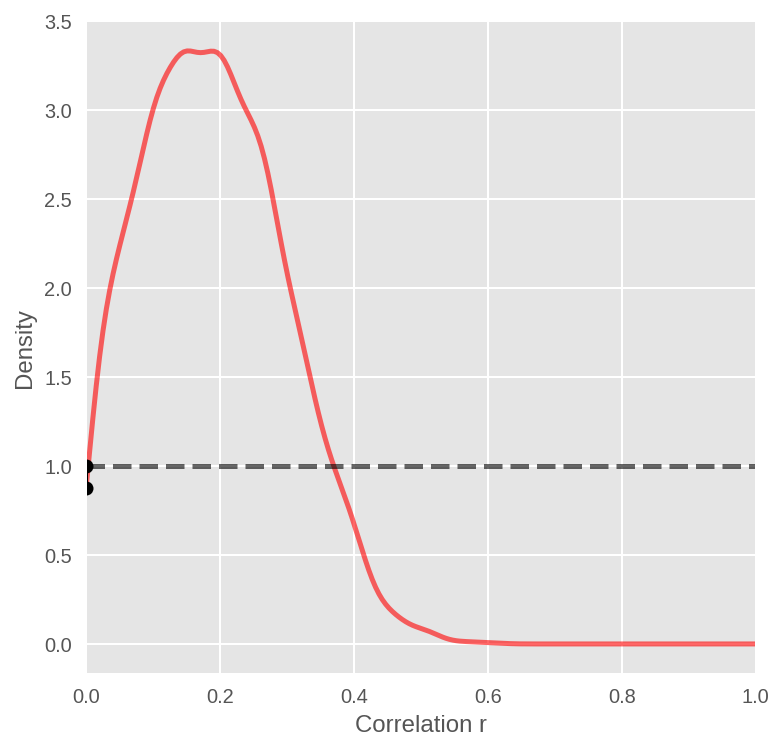

In [9]:
from scipy.stats.kde import gaussian_kde
r = trace2['r'][1000:]

fig = plt.figure(figsize=(6, 6)) 

my_pdf = gaussian_kde(r)
x1=np.linspace(0, 1, 200)

plt.plot(x1, my_pdf(x1), 'r', lw=2.5, alpha=0.6,) # distribution function
plt.plot(x1, np.ones(x1.size), 'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)        # this gives the pdf at point delta = 0
prior     = 1       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f'%(1/BF01))
plt.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko',
         lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlim([0, 1])
plt.xlabel('Correlation r')
plt.ylabel('Density')

# Compare to exact solution Jeffreys (numerical integration):
freqr=scipy.corrcoef(xobs[:, 0]/Nt, xobs[:, 1]/Nt)
BF_Jeffex = scipy.integrate.quad(lambda rho: ((1-rho**2)**((n-1)/2)) / ((1-rho*freqr[0, 1])**((n-1)-.5)), 0, 1)
print('the exact Jeffreys Bayes Factor is %.5f'%(BF_Jeffex[0]))

plt.show()

## 13.3 Evidence for the impact of extraversion
  
$$ \mu_{1},\mu_{2} \sim \text{Gaussian}(0, .001)  $$
$$ \sigma_{1},\sigma_{2} \sim \text{InvSqrtGamma} (.001, .001)  $$
$$ r \sim \text{Uniform} (-1, 1) $$  
$$ \hat\theta_{i} \sim \text{MvGaussian} ((\mu_{1},\mu_{2}), \begin{bmatrix}\sigma_{1}^2 & r\sigma_{1}\sigma_{2}\\r\sigma_{1}\sigma_{2} & \sigma_{2}^2\end{bmatrix}^{-1})  $$  
$$ \theta_{i1} =  \Phi(\hat\theta_{i1})$$
$$ \theta_{i2} =  100\Phi(\hat\theta_{i2})$$
$$ k_{i} \sim \text{Binomial}(\theta_{i1},n)$$
$$ x_{i} \sim \text{Gaussian}(\theta_{i2},\lambda^x)$$

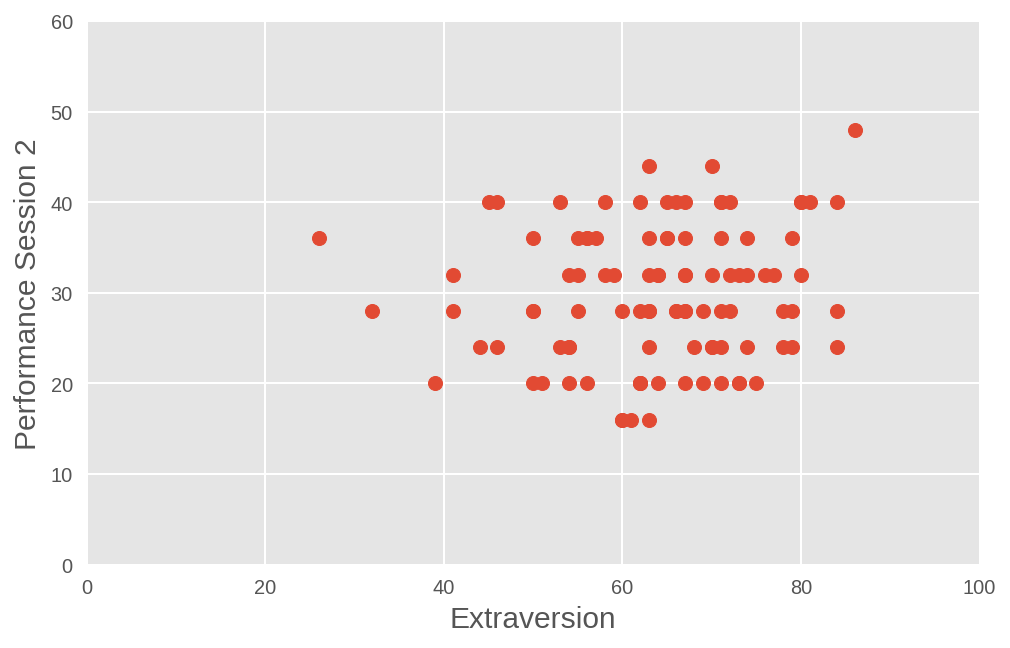

In [10]:
k2 = np.array([36, 32, 36, 36, 28, 40, 40, 24, 36, 36, 28, 40, 28, 
       36, 20, 24, 24, 16, 20, 32, 40, 32, 36, 24, 28, 44,
       40, 36, 40, 32, 32, 40, 28, 20, 24, 32, 24, 24, 20, 
       28, 24, 28, 28, 32, 20, 44, 16, 36, 32, 28, 24, 32,
       40, 28, 32, 32, 28, 24, 28, 40, 28, 20, 20, 20, 24,
       24, 36, 28, 20, 20, 40, 32, 20, 36, 28, 28, 24, 20,
       28, 32, 48, 24, 32, 32, 40, 40, 40, 36, 36, 32, 20,
       28, 40, 32, 20, 20, 16, 16, 28, 40])
       
x2 = np.array([50, 80, 79, 56, 50, 80, 53, 84, 74, 67, 50, 45, 62, 
       65, 71, 71, 68, 63, 67, 58, 72, 73, 63, 54, 63, 70, 
       81, 71, 66, 74, 70, 84, 66, 73, 78, 64, 54, 74, 62, 
       71, 70, 79, 66, 64, 62, 63, 60, 56, 72, 72, 79, 67, 
       46, 67, 77, 55, 63, 44, 84, 65, 41, 62, 64, 51, 46,
       53, 26, 67, 73, 39, 62, 59, 75, 65, 60, 69, 63, 69, 
       55, 63, 86, 70, 67, 54, 80, 71, 71, 55, 57, 41, 56, 
       78, 58, 76, 54, 50, 61, 60, 32, 67])
       
nsubjs = len(k2)
ntrials = 60
sigmax = 3

plt.figure(figsize=[8, 5])
plt.scatter(x2, k2)
plt.xlabel('Extraversion', fontsize=15)
plt.ylabel('Performance Session 2', fontsize=15)
plt.axis([0,100,0,60])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 3500/3500.0 [01:10<00:00, 44.22it/s]/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



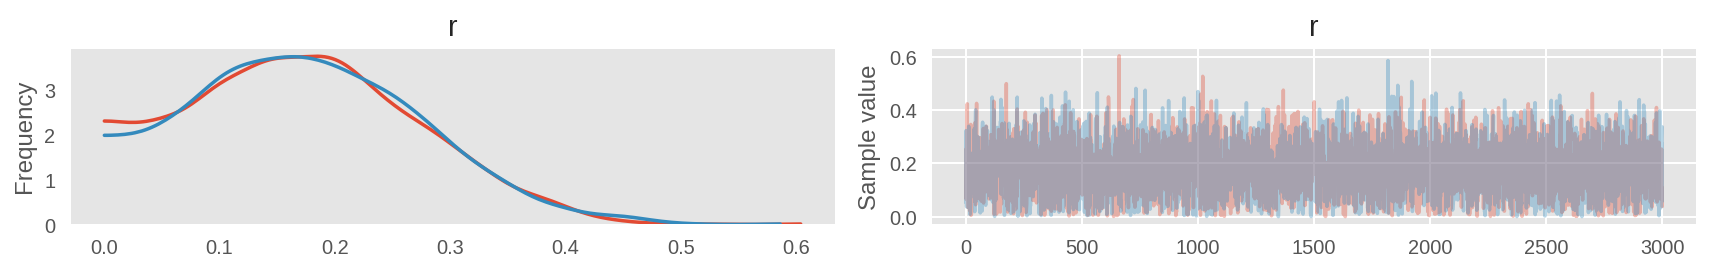

In [12]:
with pm.Model() as model3:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r', lower=0, upper=1)
    
    # μ1,μ2∼Gaussian(0,.001)
    mu = pm.Normal('mu', mu=0, tau=.001, shape=n2)
    
    # σ1,σ2∼InvSqrtGamma(.001,.001)
    lambda1 = pm.Gamma('lambda1', alpha=.001, beta=.001, testval=100)
    lambda2 = pm.Gamma('lambda2', alpha=.001, beta=.001, testval=100)
    sigma1 = pm.Deterministic('sigma1', 1/np.sqrt(lambda1))
    sigma2 = pm.Deterministic('sigma2', 1/np.sqrt(lambda2))
    
    cov = pm.Deterministic('cov', tt.stacklists([[lambda1**-1, r*sigma1*sigma2],
                                                [r*sigma1*sigma2, lambda2**-1]]))
    
    tau1 = pm.Deterministic('tau1', tt.nlinalg.matrix_inverse(cov))
    
    thetai = pm.MvNormal('thetai', mu=mu, tau=tau1, shape=(n, n2))
    theta1 = phi(thetai[:,0])
    theta2 = 100 * phi(thetai[:,1])
    
    ki = pm.Binomial('ki', p=theta1, n=Nt, observed=k2)
    xi = pm.Normal('xi', mu=theta2, sd=sigmax, observed=x2)
    
    trace3=pm.sample(3e3, njobs=2)

pm.traceplot(trace3, varnames=['r']);

the Bayes Factor is 0.48178


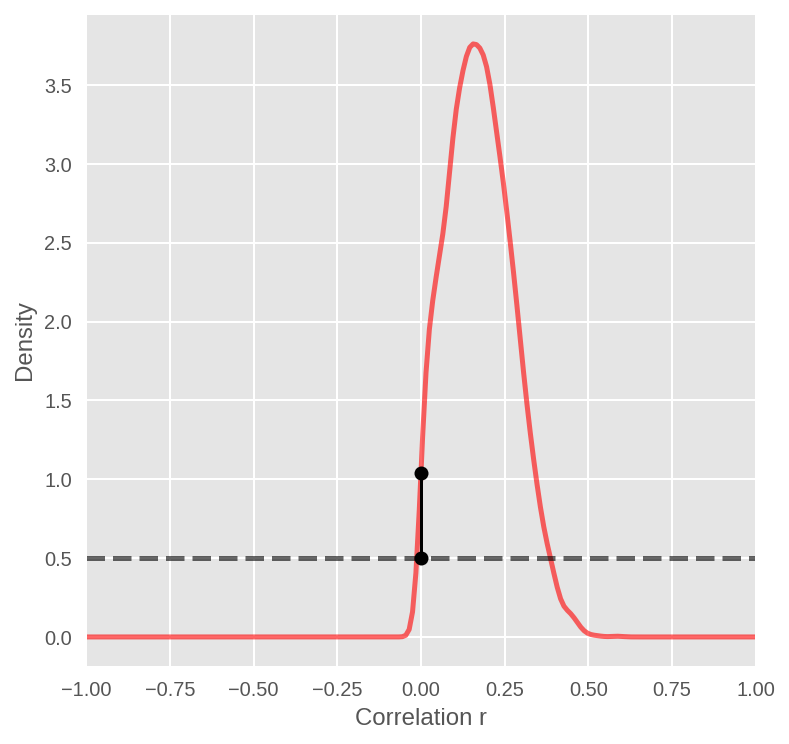

In [13]:
r = trace3['r'][1000:]

fig = plt.figure(figsize=(6, 6)) 

my_pdf = gaussian_kde(r)
x1=np.linspace(-1, 1, 200)

plt.plot(x1, my_pdf(x1), 'r', lw=2.5, alpha=0.6,) # distribution function
plt.plot(x1, np.ones(x1.size)*.5, 'k--', lw=2.5, alpha=0.6, label='Prior')
posterior = my_pdf(0)        # this gives the pdf at point delta = 0
prior     = .5       # height of order-restricted prior at delta = 0
BF01      = posterior/prior
print ('the Bayes Factor is %.5f'%(1/BF01))
plt.plot([0, 0], [posterior, prior], 'k-', 
         [0, 0], [posterior, prior], 'ko',
         lw=1.5, alpha=1)
# ax1.hist(r, bins=100, normed=1,alpha=.3)
plt.xlim([-1, 1])
plt.xlabel('Correlation r')
plt.ylabel('Density')

plt.show()